#### Next-Generation Reservoir Computing (ngrc) basic prediction and inference notebook

This notebook shows two examples of how to set up a prediction and inference task using 
the ngrc implementation in scan.

The implementation follows this concept:

1. initialize a ngrc class and define all hyperparameters there
2. applying ngrc.fit() to train the ngrc states given some training data
3. use predict() or inference() to apply the trained ngrc


In [94]:
import numpy as np
import matplotlib.pyplot as plt
import scan

### Lorenz Prediction

To predict the Lorenz system we can first of all create some simulation data using scan.simulations

In [95]:
simulations_steps = 500
starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
sim_data = scan.simulations.Lorenz63(dt=2e-2).simulate(time_steps=simulations_steps, starting_point=starting_point)

Next we define some training data used to train the ngrc.

In [96]:
train_steps = 400
train_data = sim_data[:train_steps]

We then set up the ngrc architecture by initialising the NGRC class and defining custom hyperparameters.

'regression_parameter': Regression parameter for ridge regression.

'k': required parameter of this class and defines how many data points the ngrc considers to create a ngrc state vector.

's':  required parameter. It defines how far these k data points are separated from each other in terms of their index distance.

'orders': list of ints, where one can specify the orders (ints) of the unique monomials in the ngrc state vectors.

'mode': specify on what the ngrc should be trained on. 
1. Prediction tasks:
   1. 'coordinates': ngrc learns to predict the next coordinate of the time series.
   2. 'differences': ngrc learns to predict the difference between the current coordinate and the next one.
   During prediction this difference is added to the current coordinate to make the prediction.

2. Inference tasks:
   1. 'inference': ngrc requires target_data during ngrc.fit(). Than it learns to map the ngrc vectors onto the target data. 
   
'bias' bool. If true, adds a bias term to the ngrc state vectors.

In [97]:
ngrc = scan.ngrc.NGRC(regression_parameter=9*10**-2,
    k=2,
    s=1,
    orders=[1,2],
    mode="coordinates"
    )

After initialisation, we can create and train the ngrc in relation to the 'mode' of the ngrc using the training data.

In [98]:
ngrc.fit(train_data)

Now we are able to make some predictions with ngrc.

Note: starting_series is optional. If not specified like below, ngrc starts predicting from last data point in the training data. Minimal size of starting_series needs to be at least the warmup time of ngrc $(k-1)*s +1$.

In [99]:
lorenz_prediction = ngrc.predict(steps=2000,starting_series=sim_data[-(ngrc._k-1)*ngrc._s-1+train_steps:train_steps])

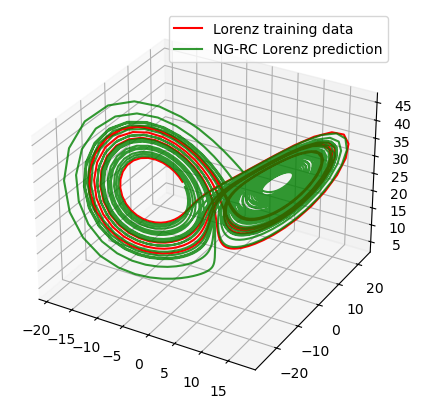

In [100]:
fig1 = plt.figure(figsize=(8, 5), dpi=100)

ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot(sim_data[:train_steps,0], sim_data[:train_steps,1], sim_data[:train_steps,2],
        alpha=1, color='red', label='Lorenz training data')
ax1.plot(lorenz_prediction[:,0], lorenz_prediction[:,1], lorenz_prediction[:,2],
        alpha=.8, color='green', label='NG-RC Lorenz prediction')

plt.legend()
plt.show()

### Lorenz inference

This example shows the 'inference' mode of the ngrc implementation.
We are trying to learn to map the $x$ and $y$ coordinates of the Lorenz system to its $z$ coordinate.
To do this, we define the $x$ and $y$ time series as training data and the $z$ time series as target data.

In [101]:
simulation_time_steps = 10000

starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
sim_data = scan.simulations.Lorenz63(dt=5e-2).simulate(time_steps=simulation_time_steps, starting_point=starting_point)

x_y_train_data = sim_data[:,:-1]
z_target_data = sim_data[:,-1]

train_steps = 1000
train_data = x_y_train_data[:train_steps]
target_data = z_target_data[:train_steps]

test_data = sim_data[:,:-1]

By initializing the ngrc class we set mode='inference'.
Now we can use the y_target argument in ngrc.fit(), this specifies that the ngrc states of 'train_data' are now trained on 'y_target'.

In [103]:
ngrc = scan.ngrc.NGRC(regression_parameter=0.001,
    k=4,
    s=5,
    orders=[1,2],
    mode='inference',
    bias = True
    )

ngrc.fit(x=train_data,y_target=target_data)

Now we can use the trained ngrc to infer the $z$ coordinates from some $x$ and $y$ test time series data of the Lorenz system.

In [104]:
lorenz_inference=ngrc.inference(test_data)

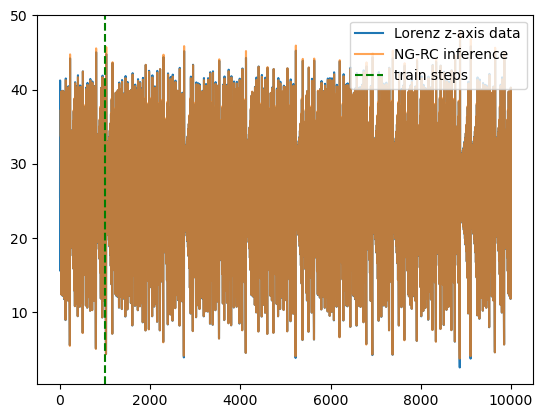

In [105]:
warm_up_time = (ngrc._k-1)*ngrc._s 
plt.plot(np.arange(0,simulation_time_steps),z_target_data,label='Lorenz z-axis data')
plt.plot(np.arange(warm_up_time,simulation_time_steps),lorenz_inference,label='NG-RC inference',alpha=0.7)
plt.axvline(x = train_steps,color='green',label = 'train steps',ls = '--')

plt.legend()
plt.show()